# Summary

## DistilBERT

# Code

In [1]:
#@title Installs

!pip install pydot --quiet
!pip install -q transformers==4.37.2

# !pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 21.3 MB/s eta 0:00:00


In [2]:
#@title Imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import TFDistilBertModel, DistilBertConfig, DistilBertTokenizer


## Load Data

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

# Data Path
train_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/train_data_binary.csv'
test_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/test_data_binary.csv'

# Load Raw Data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

Mounted at /content/gdrive


## Data Overview

In [4]:
train_data.head()

,Comment,Labels
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
train_data.shape

(159571, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

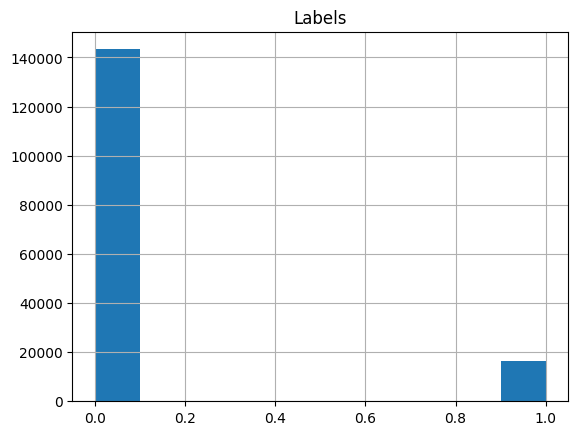

In [6]:
train_data.hist()

In [7]:
train_data['Labels'].value_counts()

Labels
0    143346
1     16225
Name: count, dtype: int64

In [8]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", train_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
train_subset, _ = train_test_split(train_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
train_subset.reset_index(drop=True, inplace=True)
train_under = train_subset
print("After random undersampling", train_under['Labels'].value_counts())

Before random undersampling Labels
0    143346
1     16225
Name: count, dtype: int64
After random undersampling Labels
0    57280
1     6548
Name: count, dtype: int64


In [9]:
test_data.head()

,Comment,Labels
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \n\n It says it right there that it IS a typ...",0
4,""" \n\n == Before adding a new product to the l...",0


In [10]:
test_data.shape

(63978, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

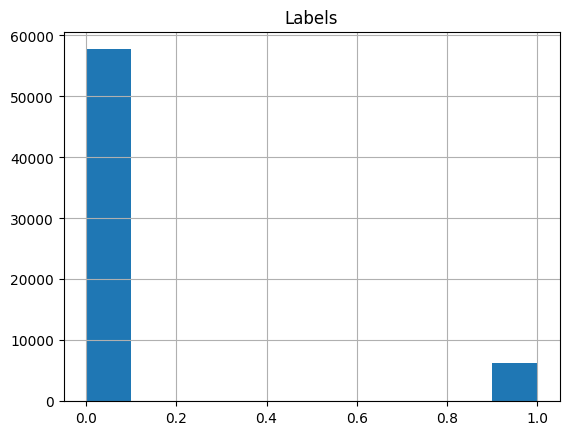

In [11]:
test_data.hist()

In [12]:
test_data['Labels'].value_counts()

Labels
0    57735
1     6243
Name: count, dtype: int64

In [13]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", test_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
test_subset, _ = train_test_split(test_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
test_subset.reset_index(drop=True, inplace=True)
test_under = test_subset
print("After random undersampling", test_under['Labels'].value_counts())

Before random undersampling Labels
0    57735
1     6243
Name: count, dtype: int64
After random undersampling Labels
0    23130
1     2461
Name: count, dtype: int64


## Create train_texts, train_labels, valid_texts, valid_labels, test_texts, and test_labels

In [14]:
# Splitting the data into train and validation sets
train_data, val_data = train_test_split(train_under, test_size=0.2, random_state=42)

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [15]:
train_texts = train_data['Comment']
train_texts

0        Christianity is only mentioned three times in ...
1        My Thoughts \n\nYou're a fucking piece of shit...
2        "\nIf you want to customize your userpage, you...
3                          Exactly how are my edits so bad
4        "\n If you'd actually take the time to look ar...
                               ...                        
51057    "\n\nThats not very nice for the people of San...
51058    November 2007 (UTC)\n\nI've been thinking of t...
51059    Track map? \n\nCan a track map be made by jdjo...
51060     "\nOK, but are they ""most"" ? Rajyaमहाराष्ट्र "
51061    William Cooley GA Nomination \n\nHi Horologium...
Name: Comment, Length: 51062, dtype: object

In [16]:
train_labels = train_data['Labels']
train_labels

0        0
1        1
2        0
3        0
4        0
        ..
51057    0
51058    0
51059    0
51060    0
51061    0
Name: Labels, Length: 51062, dtype: int64

In [17]:
valid_texts = val_data['Comment']
valid_texts

0        "\n\nFlyer is right, reliable sources are bein...
1        "\n\n Mistake in Map \n\nHello All,\n\nThe map...
2        "\nHi Rjensen. Thanks for getting back to me. ...
3        I have made no changes to the template, only a...
4        Further update: I've now discovered that the C...
                               ...                        
12761    "\n\nAward ceremony dates\nFound a source for ...
12762    Bio means life or living!! \n\nCell isn't mech...
12763    CJ DUB Continues To Insult Wiki Editors & User...
12764    "\nIf only you had followed your own advice a ...
12765    I think we should see what the RFC determines ...
Name: Comment, Length: 12766, dtype: object

In [18]:
valid_labels = val_data['Labels']
valid_labels

0        0
1        0
2        0
3        0
4        0
        ..
12761    0
12762    0
12763    0
12764    0
12765    0
Name: Labels, Length: 12766, dtype: int64

In [19]:
test_texts = test_under['Comment']
test_texts

0        Clayton High School \n Hello, I recently remov...
1        " \n\n  Please do not vandalize pages, as you ...
2                                  ::Learn to spell, yank.
3        " \n : As a member of the community, I have re...
4        == Eschew Obfuscation == \n\n If you're intere...
                               ...                        
25586    :Are you proposing something here or opining o...
25587    :I don't think there is sufficient reason to e...
25588    " \n\n == The harm of articles == \n\n Accordi...
25589    " \n\n == Local names 2nd time == \n\n  \n\n Y...
25590                fuckin super gay ass bitch headAlamos
Name: Comment, Length: 25591, dtype: object

In [20]:
test_labels = test_under['Labels']
test_labels

0        0
1        0
2        0
3        0
4        0
        ..
25586    0
25587    0
25588    0
25589    0
25590    1
Name: Labels, Length: 25591, dtype: int64

## DistillBERT-based Classification Models

In [21]:
# Specify the model checkpoint
model_checkpoint = 'distilbert-base-uncased'

In [22]:
# Create tokenizer instance
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [23]:
max_length = 512

In [24]:
# Tokenize the train, validation, and test sets
train_encodings = distilbert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = distilbert_tokenizer(list(valid_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = distilbert_tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
train_encodings

{'input_ids': <tf.Tensor: shape=(51062, 512), dtype=int32, numpy=
array([[ 101, 7988, 2003, ...,    0,    0,    0],
       [ 101, 2026, 4301, ...,    0,    0,    0],
       [ 101, 1000, 2065, ...,    0,    0,    0],
       ...,
       [ 101, 2650, 4949, ...,    0,    0,    0],
       [ 101, 1000, 7929, ...,    0,    0,    0],
       [ 101, 2520, 4658, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(51062, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
valid_encodings

{'input_ids': <tf.Tensor: shape=(12766, 512), dtype=int32, numpy=
array([[  101,  1000, 23821, ...,     0,     0,     0],
       [  101,  1000,  6707, ...,     0,     0,     0],
       [  101,  1000,  7632, ...,     0,     0,     0],
       ...,
       [  101,  1039,  3501, ...,     0,     0,     0],
       [  101,  1000,  2065, ...,     0,     0,     0],
       [  101,  1045,  2228, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(12766, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
test_encodings

{'input_ids': <tf.Tensor: shape=(25591, 512), dtype=int32, numpy=
array([[  101, 11811,  2152, ...,     0,     0,     0],
       [  101,  1000,  3531, ...,     0,     0,     0],
       [  101,  1024,  1024, ...,     0,     0,     0],
       ...,
       [  101,  1000,  1027, ...,     0,     0,     0],
       [  101,  1000,  1027, ...,     0,     0,     0],
       [  101,  6616,  2378, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(25591, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
train_encodings.input_ids.shape

TensorShape([51062, 512])

In [ ]:
valid_encodings.input_ids.shape

TensorShape([12766, 512])

In [ ]:
test_encodings.input_ids.shape

TensorShape([25591, 512])

### CLS-Token-based Classification

In [ ]:
def create_distilbert_cls_binary_model(checkpoint = 'distilbert-base-uncased',
                                       max_sequence_length = max_length,
                                       hidden_size = 275,
                                       dropout=0.3,
                                       learning_rate=0.00001):
    """
    Build a simple classification model with DistilBERT.
    """

    # Fresh instance of the DistilBERT model
    distilbert_model = TFDistilBertModel.from_pretrained(checkpoint)

    # Define input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask_layer')

    # DistilBERT does not use token_type_ids
    distilbert_inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

    # Fetch DistilBERT outputs
    distilbert_out = distilbert_model(distilbert_inputs)

    # We use the last hidden states for classification purposes
    sequence_output = distilbert_out.last_hidden_state
    pooled_output = sequence_output[:, 0]

    # Hidden layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Classification layer
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    # Final model
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    # Compile the model
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [ ]:
# Create the DistilBERT binary classification model
distilbert_cls_binary_model = create_distilbert_cls_binary_model(checkpoint=model_checkpoint)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Train the model
distilbert_cls_binary_model_history = distilbert_cls_binary_model.fit(
    [train_encodings.input_ids, train_encodings.attention_mask],
    train_labels,
    validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask], valid_labels),
    batch_size=8,
    epochs=2
)

Epoch 1/2
6383/6383 [==============================] - 3208s 498ms/step - loss: 0.1018 - accuracy: 0.9610 - val_loss: 0.0823 - val_accuracy: 0.9687
Epoch 2/2
6383/6383 [==============================] - 3172s 497ms/step - loss: 0.0600 - accuracy: 0.9771 - val_loss: 0.0815 - val_accuracy: 0.9682


800/800 [==============================] - 496s 618ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     23130
           1       0.55      0.88      0.67      2461

    accuracy                           0.92     25591
   macro avg       0.77      0.90      0.81     25591
weighted avg       0.94      0.92      0.93     25591

ROC AUC Score: 0.9703849573449573


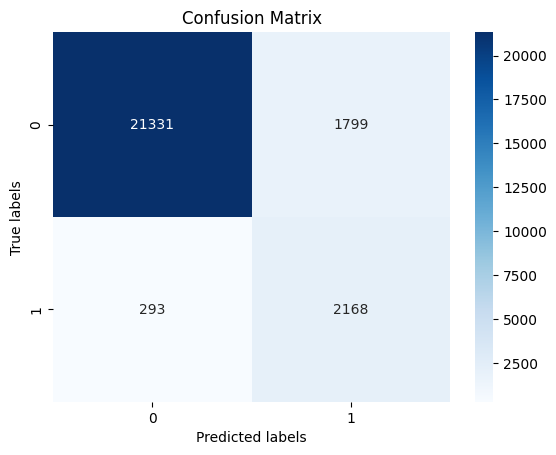

In [ ]:
#  Make predictions
predictions = distilbert_cls_binary_model.predict([test_encodings.input_ids, test_encodings.attention_mask])
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### DistilBERT + CNN

In [25]:
def create_distilbert_cnn_model(checkpoint='distilbert-base-uncased',
                                max_sequence_length=512,
                                num_filters=[131, 127, 51, 23, 17],
                                kernel_sizes=[2, 3, 4, 5, 7],
                                dropout=0.3,
                                hidden_size=275,
                                learning_rate=0.00001):
    """
    Build a classification model with DistilBERT and CNN layers.
    """

    # Load DistilBERT base model
    distilbert_model = TFDistilBertModel.from_pretrained(checkpoint)
    distilbert_model.trainable = True

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask_layer')

    # DistilBERT output
    distilbert_inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
    distilbert_out = distilbert_model(distilbert_inputs)
    sequence_output = distilbert_out.last_hidden_state  # Using the sequence output for convolution

    # CNN layers
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(sequence_output)
        conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = tf.keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    # Dropout and Hidden layers
    hidden = tf.keras.layers.Dropout(dropout)(conv_output)
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(hidden)

    # Classification layer
    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

    # Final model
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    return classification_model

In [26]:
distilbert_cnn_binary_model = create_distilbert_cnn_model(checkpoint=model_checkpoint)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [27]:
# Train the model
distilbert_cnn_binary_model_history = distilbert_cnn_binary_model.fit(
    [train_encodings.input_ids, train_encodings.attention_mask],
    train_labels,
    validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask], valid_labels),
    batch_size=8,
    epochs=2
)

Epoch 1/2
6383/6383 [==============================] - 3388s 526ms/step - loss: 0.1054 - accuracy: 0.9600 - val_loss: 0.0819 - val_accuracy: 0.9682
Epoch 2/2
6383/6383 [==============================] - 3349s 525ms/step - loss: 0.0623 - accuracy: 0.9755 - val_loss: 0.0933 - val_accuracy: 0.9655


800/800 [==============================] - 514s 640ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     23130
           1       0.46      0.95      0.62      2461

    accuracy                           0.89     25591
   macro avg       0.73      0.91      0.78     25591
weighted avg       0.94      0.89      0.90     25591

ROC AUC Score: 0.9701151715134833


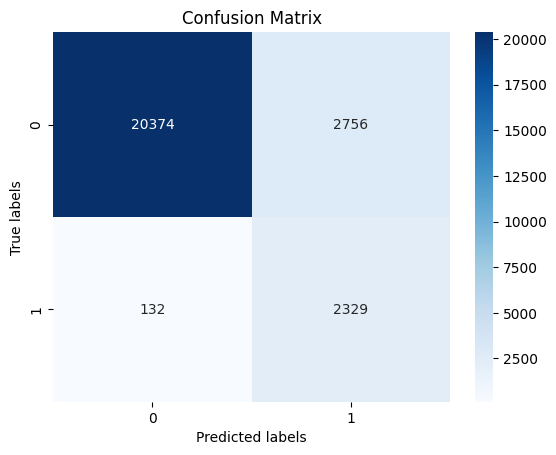

In [28]:
#  Make predictions
predictions = distilbert_cnn_binary_model.predict([test_encodings.input_ids, test_encodings.attention_mask])
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()